## 4.6 回到端到端模型执行

In [3]:
from __future__ import annotations
import numpy as np
import tvm
from tvm import relax
from tvm.script import tir as T
from tvm.script import relax as R
from tvm import IRModule

In [4]:
import IPython


def code2html(code):
    """Helper function to use pygments to turn the code string into highlighted html."""
    import pygments
    from pygments.formatters import HtmlFormatter
    from pygments.lexers import Python3Lexer
    formatter = HtmlFormatter()
    html = pygments.highlight(code, Python3Lexer(), formatter)
    return "<style>%s</style>%s\n" % (formatter.get_style_defs(".highlight"), html)

In [5]:
import torch
import torchvision

test_data = torchvision.datasets.FashionMNIST(
    root="data",
    train=False,
    download=True,
    transform=torchvision.transforms.ToTensor()
)
test_loader = torch.utils.data.DataLoader(test_data, batch_size=1, shuffle=False)
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

img, label = next(iter(test_loader))
img = img.reshape(1, 28, 28).numpy()

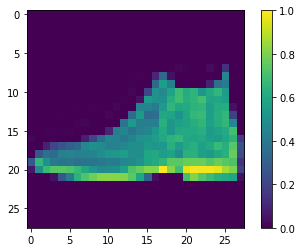

Class: Ankle boot


In [6]:
import matplotlib.pyplot as plt

plt.figure()
plt.imshow(img[0])
plt.colorbar()
plt.grid(False)
plt.show()

print("Class:", class_names[label[0]])

In [7]:
import pickle as pkl

mlp_params = pkl.load(open("fasionmnist_mlp_params.pkl", "rb"))

data_nd = tvm.nd.array(img.reshape(1, 784))
nd_params = {k: tvm.nd.array(v) for k, v in mlp_params.items()}

In [8]:
@tvm.register_func(func_name='env.relu', override=True)
def torch_relu(x: tvm.nd.NDArray,
               out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    out_torch = torch.from_dlpack(out)
    torch.maximum(x_torch, torch.Tensor([0.0]), out=out_torch)

@tvm.register_func(func_name='env.linear', override=True)
def torch_linear(x: tvm.nd.NDArray,
                 w: tvm.nd.NDArray,
                 b: tvm.nd.NDArray,
                 out: tvm.nd.NDArray):
    x_torch = torch.from_dlpack(x)
    w_torch = torch.from_dlpack(w)
    b_torch = torch.from_dlpack(b)
    out_torch = torch.from_dlpack(out)
    torch.matmul(x_torch, w_torch.T, out=out_torch)
    torch.add(out_torch, b_torch, out=out_torch)

In [55]:
@tvm.script.ir_module
class MyModuleMixture():
    @T.prim_func
    def linear0(x: T.Buffer[(1, 784), 'float32'],
                w0: T.Buffer[(128, 784), 'float32'],
                b0: T.Buffer[(128,), 'float32'],
                z: T.Buffer[(1, 128), 'float32']):
        T.func_attr({"global_symbol": "linear0", 'tir.noalias': True})
        lv0 = T.alloc_buffer((1, 128), dtype='float32')
        for i, j, k in T.grid(1, 128, 784):
            with T.block('lv0'):
                vi, vj, vk = T.axis.remap("SSR", [i, j, k])
                with T.init():
                    lv0[vi, vj] = T.float32(0)
                lv0[vi, vj] = lv0[vi, vj] + x[vi, vk] * w0[vj, vk]
        
        for i, j in T.grid(1, 128):
            with T.block('C'):
                vi, vj = T.axis.remap('SS', [i, j])
                z[vi, vj] = lv0[vi, vj] + b0[vj]
    
    @R.function
    def main(x: R.Tensor((1, 784), 'float32'),
             w0: R.Tensor((128, 784), 'float32'),
             b0: R.Tensor((128,), 'float32'),
             w1: R.Tensor((10, 128), 'float32'),
             b1: R.Tensor((10,), 'float32')):
        #  
        with R.dataflow():
            lv0 = R.call_tir(linear0, (x, w0, b0), relax.TensorStructInfo((1, 128), 'float32'))
            lv1 = R.call_tir('env.relu', (lv0,), relax.TensorStructInfo((1, 128), 'float32'))
            out = R.call_tir('env.linear', (lv1, w1, b1), relax.TensorStructInfo((1, 10), 'float32'))
            R.output(out)
        return out

In [56]:
MyModuleWithParams = relax.transform.BindParams("main", nd_params)(MyModuleMixture)
IPython.display.HTML(code2html(MyModuleWithParams.script()))

In [57]:

ex = relax.vm.build(MyModuleWithParams, target="llvm")
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm["main"](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams Prediction:", class_names[pred_kind[0]])

MyModuleWithParams Prediction: Ankle boot


In [58]:
f_timer_before = vm.time_evaluator('main', tvm.cpu(), number=1000)
print("MyModuleWithParams time-cost: %g ms" % (f_timer_before(data_nd).mean * 1000))

MyModuleWithParams time-cost: 0.231714 ms


目前，调优 API 只接受一个带有一个 main 函数的 IRModule，所以我们首先将 linear0 取出到另一个模块的 main 函数中并将其传递给 tune_tir.

In [60]:
mod_linear = tvm.IRModule.from_expr(MyModuleMixture['linear0'].with_attr("global_symbol", 'main'))
IPython.display.HTML(code2html(mod_linear.script()))

In [61]:
import tvm.meta_schedule as ms

tuned_record = ms.tune_tir(mod_linear, target='llvm --num-cores=1',
                            work_dir='./tune_tmp/',
                            task_name='main',
                            max_trials_global=64,
                            num_trials_per_iter=64)

2023-02-08 22:52:13 [INFO] [task_scheduler.cc:260] Task #0 has finished. Remaining task(s): 0


,Name,FLOP,Weight,Speed (GFLOPS),Latency (us),Weighted Latency (us),Trials,Done
0,main,200832,1,40.0325,5.0167,5.0167,64,Y


2023-02-08 22:52:13 [DEBUG] [task_scheduler.cc:318] 
 ID | Name |   FLOP | Weight | Speed (GFLOPS) | Latency (us) | Weighted Latency (us) | Trials | Done 
-----------------------------------------------------------------------------------------------------
  0 | main | 200832 |      1 |        40.0325 |       5.0167 |                5.0167 |     64 |    Y 
-----------------------------------------------------------------------------------------------------
Total trials: 64
Total latency (us): 5.01673



In [75]:
MyModuleWithParams2 = relax.transform.BindParams('main', nd_params)(MyModuleMixture)
sch_tuned_linear = ms.tir_integration.compile_tir(tuned_record, mod_linear, target='llvm')
new_func = sch_tuned_linear.mod['main'].with_attr("global_symbol", "linear0")
# IPython.display.HTML(code2html(new_func.script()))
# print(type(sch_tuned_linear.mod['main']))
gv = MyModuleWithParams2.get_global_var('linear0')
MyModuleWithParams2.update_func(gv, new_func)
IPython.display.HTML(code2html(MyModuleWithParams2.script()))

In [79]:
ex = relax.vm.build(MyModuleWithParams2, target='llvm')
vm = relax.VirtualMachine(ex, tvm.cpu())

nd_res = vm['main'](data_nd)

pred_kind = np.argmax(nd_res.numpy(), axis=1)
print("MyModuleWithParams2 Prediction:", class_names[pred_kind[0]])


MyModuleWithParams2 Prediction: Ankle boot


In [80]:
f_timer_after = vm.time_evaluator('main', tvm.cpu(), number=1000)

print("MyModuleWithParams2 time-cost: %g ms" % (f_timer_after(data_nd).mean * 1000))

MyModuleWithParams2 time-cost: 0.121606 ms


## 4.7 discuss
前两章关注的是抽象，而本章开始关注变换。随机变换指定了可以优化的内容，而无需显式地确定所有选择。Meta-Schedule API 帮助我们搜索可能的变换空间并选择最佳变换. 


将搜索结果放回端到端流程只是将原始函数的实现替换为调优后的新函数的实现. 

一个好的 MLC 流程将这些变换组合在一起，形成最终部署的形式

## 4.8 概括
随机变换帮助我们指定**可能程序的搜索空间**（基于模板 & ansor）。

**Meta-Schedule** 在搜索空间中搜索，并找到优化后的程序。

我们可以使用另一种变换，将初始的元张量函数**替换**为优化后的函数，并更新端到端执行流程。